# 3.1 Pretext Tasks

In this part of the tutorial we will pretrain a model on a pretext task. Pretext tasks are useful for data scarcity and transfer learning, as they are unsupervised ways for the model to capture general patterns present in the data as a warmup. Then, *hopefully* the same model can be effectively fine tuned on the downstream the task of interest.

In [1]:
import torch
import torch.nn as nn
from torchvision.datasets import MNIST
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset

import matplotlib.pyplot as plt
from tqdm import tqdm
from typing import Tuple

torch.manual_seed(0);

## Data

We will be working again with the MNIST dataset. The pretext task is *image inpainting*. Essentially, a portion of the image is erased and we will train an autoencoder to reconstruct the original image. Then, we can use the encoder of our autoencoder as a pretrained backbone for a very simple model that will be tasked to classify the digits.

We start by defining our dataset. We will be using `RandomErasing` as data augmentation. Feel free to add more and experiment!

In [2]:
class AugmentedMNIST(Dataset):
    def __init__(self):
        self.augmentation_transform = transforms.Compose([
            transforms.RandomErasing(
                p=.8, # Probability of applying the augmentation
                value=.5, # Value to fill the mask
                scale=(.20, .25), # Range of what proportion of the image is erased (here it is between 20% and 25%)
                ratio=(.5, 2) # Range of aspect ratio of the erased rectangular region (here between 1:2 and 2:1)
            )
        ])
        self.to_tensor = transforms.ToTensor()
        self.mnist = MNIST('data', download=True)
    
    def __len__(self):
        return len(self.mnist)
    
    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        image, label = self.mnist[idx]
        image_tensor = self.to_tensor(image)
        augmented_image_tensor = self.augmentation_transform(image_tensor)
        return augmented_image_tensor, image_tensor, labele

dataset = AugmentedMNIST()
dataloader = DataLoader(dataset, batch_size=100, shuffle=True)

Let's visualize a few images and their augmented versions

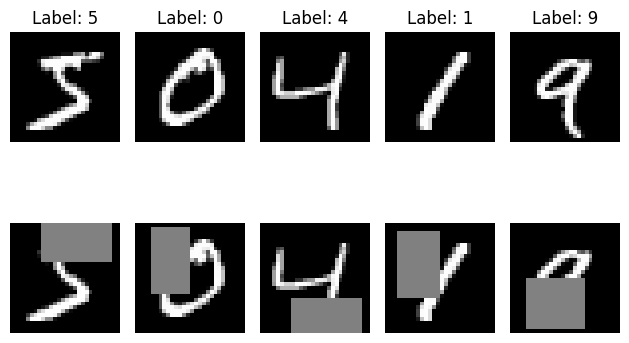

In [3]:
fig, ax = plt.subplots(nrows=2, ncols=5)

for i in range(5):
    augmentation, image, label = dataset[i]
    ax[0][i].imshow(image[0], cmap='gray')
    ax[1][i].imshow(augmentation[0], cmap='gray')
    ax[0][i].set_title(f'Label: {label}')
    ax[0][i].axis('off')
    ax[1][i].axis('off')
plt.tight_layout()
plt.show()

It is looking good! Let us now define our simple autoencoder:

## Model

In [4]:
class AutoEncoder(nn.Module):
    
    def __init__(self) -> None:
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28*28, 128),
            nn.ReLU(),
            nn.Linear(128, 32),
        )
        self.decoder = nn.Sequential(
            nn.Linear(32, 128),
            nn.ReLU(),
            nn.Linear(128, 28*28),
            nn.Sigmoid()
        )
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.encoder(x)
        x = self.decoder(x)
        return x

autoencoder = AutoEncoder()
sum(p.numel() for p in autoencoder.parameters())

209968

Our autoencoder includes a bit more than 200 000 parameters and its latent space is 32-dimensional, i.e. 6% of the original input space (28 x 28). Feel free to change the architecture!

## Training

In [5]:
loss_fn = nn.BCELoss()
optimizer_autoencoder = torch.optim.Adam(autoencoder.parameters())

Similarly to last week, the loss function is the reconstruction loss, i.e., binary cross entropy. Now we are ready to train! The workflow is as always:

In [6]:
for epoch in range(5):
    autoencoder.train()
    total_loss = 0.
    for X, y, _ in tqdm(dataloader):

        # Inputs: Augmented images
        # Labels: Original images
        X, y = X.flatten(1), y.flatten(1)
        
        optimizer_autoencoder.zero_grad()
        y_pred = autoencoder(X)
        loss = loss_fn(y_pred, y)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    print(f"Epoch {epoch} | Loss: {total_loss/len(dataloader):.4f}")

100%|█████████████████████████████████████████| 600/600 [00:14<00:00, 42.52it/s]


Epoch 0 | Loss: 0.2240


100%|█████████████████████████████████████████| 600/600 [00:15<00:00, 39.53it/s]


Epoch 1 | Loss: 0.1624


100%|█████████████████████████████████████████| 600/600 [00:15<00:00, 39.54it/s]


Epoch 2 | Loss: 0.1486


100%|█████████████████████████████████████████| 600/600 [00:14<00:00, 41.75it/s]


Epoch 3 | Loss: 0.1419


100%|█████████████████████████████████████████| 600/600 [00:15<00:00, 38.77it/s]

Epoch 4 | Loss: 0.1378


## Evaluation

Our model is definitely learning. Let's visualize some reconstructions:

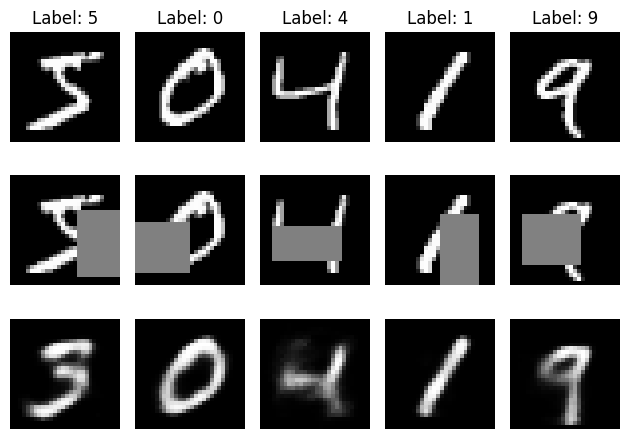

In [7]:
fig, ax = plt.subplots(nrows=3, ncols=5)

for i in range(5):
    augmentation, image, label = dataset[i]
    ax[0][i].imshow(image[0], cmap='gray')
    ax[1][i].imshow(augmentation[0], cmap='gray')
    with torch.inference_mode():
        reconstruction = autoencoder(augmentation.flatten(1)).reshape(28, 28)
    ax[2][i].imshow(reconstruction, cmap='gray')
    
    ax[0][i].set_title(f'Label: {label}')
    ax[0][i].axis('off')
    ax[1][i].axis('off')
    ax[2][i].axis('off')
    
plt.tight_layout()
plt.show()

## Your Task

It appears that our model is doing a semi-decent job at filling the images. Now let us use the encoder as a backbone of a very simple classifier. In our case, that could be a single linear layer that projects the latent space to the class dimension, which would be equivalent to fitting a regular logistic regression on our latent space. See the performance after a few epochs and try to quantitatively describe the effect of the pretrained backbone!

In [ ]:
# Your code here